# Packages used

In [449]:
import pandas as pd
import pyarrow
import os

import polyline
from statistics import mean
import numpy as np

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from datetime import datetime, timedelta
import calendar

#import geopandas as gpd
#from shapely.geometry import Point
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib import cm
import matplotlib.dates as mdates
# enable matplotlib display static plot within jupyter notebook
%matplotlib inline 


# Set the display options to show all columns
pd.set_option('display.max_columns', None)

# Importing the data 

In [674]:
# This only works if you are in a "Strava" folder

# Get the current directory path
current_directory = os.getcwd()

# Split the path into drive and path components
drive, path = os.path.splitdrive(current_directory)

# if were are in a folder below Strava (the root)
if os.path.basename(os.path.dirname(path)) == 'Strava':
    strava_data_directory = os.path.join(drive,os.path.dirname(path),'data')
else:
    strava_data_directory = os.path.join(drive,os.path.dirname(path),'Strava','data')

os.chdir(strava_data_directory)

# Verify the updated current directory
print("Current directory:", os.getcwd())

Current directory: c:\Users\arnarh\repos\Strava\data


In [675]:
df = pd.read_parquet('all_activities_detailed_clientId_38924_20230618.parquet')
df_copy = df.copy # so if I screw up something I can call this df

In [676]:
df.head()

resource_state                       name  distance  moving_time  \
0               3             Afternoon Ride    2625.1          432   
1               3          Afternoon Workout       0.0         3885   
2               3             Afternoon Ride    2591.5          468   
3               3  Afternoon Weight Training       0.0         2613   
4               3             Afternoon Ride   27297.2         3882   

   elapsed_time  total_elevation_gain            type      sport_type  \
0           432                   8.0            Ride            Ride   
1          3885                   0.0         Workout         Workout   
2           488                  39.0            Ride            Ride   
3          2613                   0.0  WeightTraining  WeightTraining   
4          3926                 200.0            Ride            Ride   

   workout_type          id            start_date      start_date_local  \
0           NaN  9284284353  2023-06-17T17:59:09Z  2023-06-17T17:59:09Z   
1           NaN  9284221687  2023-06-17T16:49:44Z  2023-06-17T16:49:44Z   
2           NaN  9283841624  2023-06-17T16:38:18Z  2023-06-17T16:38:18Z   
3           NaN  9277827977  2023-06-16T17:22:14Z  2023-06-16T17:22:14Z   
4           NaN  9276884908  2023-06-16T14:00:48Z  2023-06-16T14:00:48Z   

                         timezone  utc_offset location_city location_state  \
0  (GMT+00:00) Atlantic/Reykjavik         0.0          None           None   
1      (GMT+00:00) Africa/Abidjan         0.0          None           None   
2  (GMT+00:00) Atlantic/Reykjavik         0.0          None           None   
3      (GMT+00:00) Africa/Abidjan         0.0          None           None   
4  (GMT+00:00) Atlantic/Reykjavik         0.0          None           None   

  location_country  achievement_count  kudos_count  comment_count  \
0          Iceland                  0            0              0   
1          Iceland                  0            0              0   
2          Iceland                  2            0              0   
3          Iceland                  0            0              0   
4          Iceland                 27            0              0   

   athlete_count  photo_count  trainer  commute  manual  private visibility  \
0              1            0    False    False   False     True    only_me   
1              1            0     True    False   False     True    only_me   
2              1            0    False    False   False     True    only_me   
3              1            0     True    False   False     True    only_me   
4              1            0    False    False   False     True    only_me   

   flagged   gear_id                              start_latlng  \
0    False  b7503439   [64.13658767938614, -21.75912600941956]   
1    False      None                                        []   
2    False  b7503439  [64.15314671583474, -21.771167954429984]   
3    False      None                                        []   
4    False  b7503439  [64.15290037170053, -21.772008575499058]   

                                 end_latlng  average_speed  max_speed  \
0  [64.15261480025947, -21.772179901599884]          6.077      8.620   
1                                        []          0.000      0.000   
2  [64.13656345568597, -21.758576575666666]          5.537      7.772   
3                                        []          0.000      0.000   
4    [64.15301755070686, -21.7714521009475]          7.032     11.246   

   average_watts  kilojoules device_watts  has_heartrate  average_heartrate  \
0           84.2        36.4        False           True              121.7   
1            NaN         NaN         None           True              130.6   
2          168.7        79.0        False           True              116.3   
3            NaN         NaN         None           True              110.8   
4          139.6       541.8        False           True              104.9   

   max_heartrate

# Preprocessing

In [677]:
# List columns that contain null values
null_columns = df.columns[df.isnull().all()].tolist()
df = df.drop(null_columns, axis=1)
print(f'Dropped the following columns: {null_columns}')

Dropped the following columns: ['location_city', 'location_state', 'photos.primary']


In [678]:
# Changing distance and speed to km, time to minutes
df['distance_km'] = df['distance'] / 1000
df['moving_time_minutes'] = df['moving_time'] / 60
df['elapsed_time_minutes'] = df['elapsed_time'] / 60
df['average_speed_km_hour'] = df['average_speed'] * (18/5)
df['max_speed_km_hour'] = df['max_speed'] * (18/5)

In [679]:
df.head()

resource_state                       name  distance  moving_time  \
0               3             Afternoon Ride    2625.1          432   
1               3          Afternoon Workout       0.0         3885   
2               3             Afternoon Ride    2591.5          468   
3               3  Afternoon Weight Training       0.0         2613   
4               3             Afternoon Ride   27297.2         3882   

   elapsed_time  total_elevation_gain            type      sport_type  \
0           432                   8.0            Ride            Ride   
1          3885                   0.0         Workout         Workout   
2           488                  39.0            Ride            Ride   
3          2613                   0.0  WeightTraining  WeightTraining   
4          3926                 200.0            Ride            Ride   

   workout_type          id            start_date      start_date_local  \
0           NaN  9284284353  2023-06-17T17:59:09Z  2023-06-17T17:59:09Z   
1           NaN  9284221687  2023-06-17T16:49:44Z  2023-06-17T16:49:44Z   
2           NaN  9283841624  2023-06-17T16:38:18Z  2023-06-17T16:38:18Z   
3           NaN  9277827977  2023-06-16T17:22:14Z  2023-06-16T17:22:14Z   
4           NaN  9276884908  2023-06-16T14:00:48Z  2023-06-16T14:00:48Z   

                         timezone  utc_offset location_country  \
0  (GMT+00:00) Atlantic/Reykjavik         0.0          Iceland   
1      (GMT+00:00) Africa/Abidjan         0.0          Iceland   
2  (GMT+00:00) Atlantic/Reykjavik         0.0          Iceland   
3      (GMT+00:00) Africa/Abidjan         0.0          Iceland   
4  (GMT+00:00) Atlantic/Reykjavik         0.0          Iceland   

   achievement_count  kudos_count  comment_count  athlete_count  photo_count  \
0                  0            0              0              1            0   
1                  0            0              0              1            0   
2                  2            0              0              1            0   
3                  0            0              0              1            0   
4                 27            0              0              1            0   

   trainer  commute  manual  private visibility  flagged   gear_id  \
0    False    False   False     True    only_me    False  b7503439   
1     True    False   False     True    only_me    False      None   
2    False    False   False     True    only_me    False  b7503439   
3     True    False   False     True    only_me    False      None   
4    False    False   False     True    only_me    False  b7503439   

                               start_latlng  \
0   [64.13658767938614, -21.75912600941956]   
1                                        []   
2  [64.15314671583474, -21.771167954429984]   
3                                        []   
4  [64.15290037170053, -21.772008575499058]   

                                 end_latlng  average_speed  max_speed  \
0  [64.15261480025947, -21.772179901599884]          6.077      8.620   
1                                        []          0.000      0.000   
2  [64.13656345568597, -21.758576575666666]          5.537      7.772   
3                                        []          0.000      0.000   
4    [64.15301755070686, -21.7714521009475]          7.032     11.246   

   average_watts  kilojoules device_watts  has_heartrate  average_heartrate  \
0           84.2        36.4        False           True              121.7   
1            NaN         NaN         None           True              130.6   
2          168.7        79.0        False           True              116.3   
3            NaN         NaN         None           True              110.8   
4          139.6       541.8        False           True              104.9   

   max_heartrate  heartrate_opt_out  display_hide_heartrate_option  elev_high  \
0          130.0              False                           True       73.6   
1          171.0            

## Creating date columns

In [680]:
# Convert 'start_date' column to datetime
df['start_date'] = pd.to_datetime(df['start_date'])

# Extract the date component into a new column named 'date'
df['date'] = pd.to_datetime(df['start_date']).dt.date

In [682]:
# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Create 'year' and 'week' columns
df['year'] = df['date'].dt.year
df['week'] = df['date'].dt.isocalendar().week
df['year_week'] = df['year'].astype(str) + '-' + df['week'].astype(str)
# adding month names
df['month'] = df['date'].dt.strftime('%B')

In [683]:
df.head()

resource_state                       name  distance  moving_time  \
0               3             Afternoon Ride    2625.1          432   
1               3          Afternoon Workout       0.0         3885   
2               3             Afternoon Ride    2591.5          468   
3               3  Afternoon Weight Training       0.0         2613   
4               3             Afternoon Ride   27297.2         3882   

   elapsed_time  total_elevation_gain            type      sport_type  \
0           432                   8.0            Ride            Ride   
1          3885                   0.0         Workout         Workout   
2           488                  39.0            Ride            Ride   
3          2613                   0.0  WeightTraining  WeightTraining   
4          3926                 200.0            Ride            Ride   

   workout_type          id                start_date      start_date_local  \
0           NaN  9284284353 2023-06-17 17:59:09+00:00  2023-06-17T17:59:09Z   
1           NaN  9284221687 2023-06-17 16:49:44+00:00  2023-06-17T16:49:44Z   
2           NaN  9283841624 2023-06-17 16:38:18+00:00  2023-06-17T16:38:18Z   
3           NaN  9277827977 2023-06-16 17:22:14+00:00  2023-06-16T17:22:14Z   
4           NaN  9276884908 2023-06-16 14:00:48+00:00  2023-06-16T14:00:48Z   

                         timezone  utc_offset location_country  \
0  (GMT+00:00) Atlantic/Reykjavik         0.0          Iceland   
1      (GMT+00:00) Africa/Abidjan         0.0          Iceland   
2  (GMT+00:00) Atlantic/Reykjavik         0.0          Iceland   
3      (GMT+00:00) Africa/Abidjan         0.0          Iceland   
4  (GMT+00:00) Atlantic/Reykjavik         0.0          Iceland   

   achievement_count  kudos_count  comment_count  athlete_count  photo_count  \
0                  0            0              0              1            0   
1                  0            0              0              1            0   
2                  2            0              0              1            0   
3                  0            0              0              1            0   
4                 27            0              0              1            0   

   trainer  commute  manual  private visibility  flagged   gear_id  \
0    False    False   False     True    only_me    False  b7503439   
1     True    False   False     True    only_me    False      None   
2    False    False   False     True    only_me    False  b7503439   
3     True    False   False     True    only_me    False      None   
4    False    False   False     True    only_me    False  b7503439   

                               start_latlng  \
0   [64.13658767938614, -21.75912600941956]   
1                                        []   
2  [64.15314671583474, -21.771167954429984]   
3                                        []   
4  [64.15290037170053, -21.772008575499058]   

                                 end_latlng  average_speed  max_speed  \
0  [64.15261480025947, -21.772179901599884]          6.077      8.620   
1                                        []          0.000      0.000   
2  [64.13656345568597, -21.758576575666666]          5.537      7.772   
3                                        []          0.000      0.000   
4    [64.15301755070686, -21.7714521009475]          7.032     11.246   

   average_watts  kilojoules device_watts  has_heartrate  average_heartrate  \
0           84.2        36.4        False           True              121.7   
1            NaN         NaN         None           True              130.6   
2          168.7        79.0        False           True              116.3   
3            NaN         NaN         None           True              110.8   
4          139.6       541.8        False           True              104.9   

   max_heartrate  heartrate_opt_out  display_hide_heartrate_option  elev_high  \
0          130.0              False                           True       73.6   
1   

# Creating daily and weekly aggregated data

In [53]:
summary_columns = ['id', 'name', 'type', 'start_date', 'date', 'year', 'month','week', 'year_week', 'location_country', 'trainer', 'commute' , 'gear_id', 'start_latlng', 'end_latlng', 'calories', 'has_heartrate', 'average_heartrate', 'max_heartrate', 'elev_high', 'elev_low', 'pr_count', 'segment_efforts', 'device_name', 'map.polyline', 'map.summary_polyline'
                    , 'gear.name', 'gear.retired', 'average_cadence', 'best_efforts', 'max_watts', 'weighted_average_watts', 'distance_km', 'moving_time_minutes', 'elapsed_time_minutes', 'average_speed_km_hour', 'max_speed_km_hour']

In [54]:
df_summary = df[summary_columns]

In [55]:
df_summary.head()

id                       name            type  \
0  9284284353             Afternoon Ride            Ride   
1  9284221687          Afternoon Workout         Workout   
2  9283841624             Afternoon Ride            Ride   
3  9277827977  Afternoon Weight Training  WeightTraining   
4  9276884908             Afternoon Ride            Ride   

                 start_date       date  year month  week year_week  \
0 2023-06-17 17:59:09+00:00 2023-06-17  2023  June    24   2023-24   
1 2023-06-17 16:49:44+00:00 2023-06-17  2023  June    24   2023-24   
2 2023-06-17 16:38:18+00:00 2023-06-17  2023  June    24   2023-24   
3 2023-06-16 17:22:14+00:00 2023-06-16  2023  June    24   2023-24   
4 2023-06-16 14:00:48+00:00 2023-06-16  2023  June    24   2023-24   

  location_country  trainer  commute   gear_id  \
0          Iceland    False    False  b7503439   
1          Iceland     True    False      None   
2          Iceland    False    False  b7503439   
3          Iceland     True    False      None   
4          Iceland    False    False  b7503439   

                               start_latlng  \
0   [64.13658767938614, -21.75912600941956]   
1                                        []   
2  [64.15314671583474, -21.771167954429984]   
3                                        []   
4  [64.15290037170053, -21.772008575499058]   

                                 end_latlng  calories  has_heartrate  \
0  [64.15261480025947, -21.772179901599884]      88.0           True   
1                                        []     811.0           True   
2  [64.13656345568597, -21.758576575666666]      88.0           True   
3                                        []     385.0           True   
4    [64.15301755070686, -21.7714521009475]     470.0           True   

   average_heartrate  max_heartrate  elev_high  elev_low  pr_count  \
0              121.7          130.0       73.6      45.0         0   
1              130.6          171.0       95.8      91.4         0   
2              116.3          136.0       98.8      57.8         2   
3              110.8          149.0        NaN       NaN         0   
4              104.9          165.0      103.2      12.6        13   

                                     segment_efforts          device_name  \
0  [{'achievements': [], 'activity': {'id': 92842...  Garmin vívoactive 4   
1                                                 []  Garmin vívoactive 4   
2  [{'achievements': [{'rank': 1, 'type': 'pr', '...  Garmin vívoactive 4   
3                                                 []  Garmin vívoactive 4   
4  [{'achievements': [], 'activity': {'id': 92768...  Garmin vívoactive 4   

                                        map.polyline  \
0  stmfKpyxcC\JxBpAvA`AJ\B`AMd@MTm@h@_@PiAOiACm@F...   
1                                                      
2  c|pfKxd{cCGi@FyD@SH]z@eAzAuB^S|@WHGXUNSh@}@NK^...   
3                                                      
4  szpfK`j{cCFg@c@cBGoAAqDCQMKo@z@qAz@_@Ha@?OE{@k...   

                                map.summary_polyline          gear.name  \
0  {tnfKrhycC{AtBoApAWRSFIX@f@Vn@B\Ux@?d@T^DLb@rB...  Specialized Allez   
1                                                                  None   
2  smofKxozcCxBi@fB{@r@Ub@KhCaAx@SRS^g@DSDaA|@oCF...  Specialized Allez   
3                                                                  None   
4  gmqfKze{cCwAjB]pA]dERtEr@dD`AtHP`PQ~Ic@pDy@bDK...  Specialized Allez   

  gear.retired  average_cadence best_efforts  max_watts  \
0        False              NaN         None        NaN   
1         None              NaN         None        NaN   
2        False              NaN         None        NaN   
3         None              NaN         None        NaN   
4        False              NaN         None        NaN   

   weighted_average_watts  distance_km  moving_time_minutes  \
0                     NaN       2.6251                 7.20   
1                     NaN       0.0000                64.75

In [50]:
# count types and sum km and elapsed time for each type
df_summary_weekly = df_summary.groupby(['year_week','type']).agg({'distance_km': 'sum', 'id': 'count', 'elapsed_time_minutes':'sum', 'moving_time_minutes':'sum'})
df_summary_weekly = df_summary_weekly.rename(columns={'distance_km': 'Sum of distance_km', 'id': 'Count activites', 'elapsed_time_minutes':'Sum of elapsed_time_minutes', 'moving_time_minutes':'Sum of moving_time_minutes'}).reset_index()
df_summary_weekly.head()

year_week  type  Sum of distance_km  Count activites  \
0   2016-15  Ride             16.7906                4   
1   2016-16  Ride             15.0014                4   
2   2016-17  Ride             13.0483                4   
3   2016-19  Ride             72.6299               17   
4   2016-20  Ride             82.9416               22   

   Sum of elapsed_time_minutes  Sum of moving_time_minutes  
0                  1809.300000                   57.233333  
1                    50.400000                   47.816667  
2                    46.266667                   42.150000  
3                   268.366667                  248.950000  
4                   323.766667                  291.866667

In [144]:
# count types and sum km and elapsed time for each type
df_summary_daily = df_summary.groupby(['year','year_week','date','month','type']).agg({'distance_km': 'sum', 'id': 'count', 'elapsed_time_minutes':'sum', 'moving_time_minutes':'sum'})
df_summary_daily = df_summary_daily.rename(columns={'distance_km': 'sum_distance_km', 'id': 'count_activites', 'elapsed_time_minutes':'sum_elapsed_time_minutes', 'moving_time_minutes':'sum_moving_time_minutes'}).reset_index()
df_summary_daily.head()

year year_week       date  month  type  sum_distance_km  count_activites  \
0  2016   2016-15 2016-04-15  April  Ride           4.3717                1   
1  2016   2016-15 2016-04-16  April  Ride           3.8171                1   
2  2016   2016-15 2016-04-17  April  Ride           8.6018                2   
3  2016   2016-16 2016-04-18  April  Ride          15.0014                4   
4  2016   2016-17 2016-04-26  April  Ride           6.6897                2   

   sum_elapsed_time_minutes  sum_moving_time_minutes  
0                 20.250000                17.466667  
1               1758.633333                10.416667  
2                 30.416667                29.350000  
3                 50.400000                47.816667  
4                 22.583333                21.383333

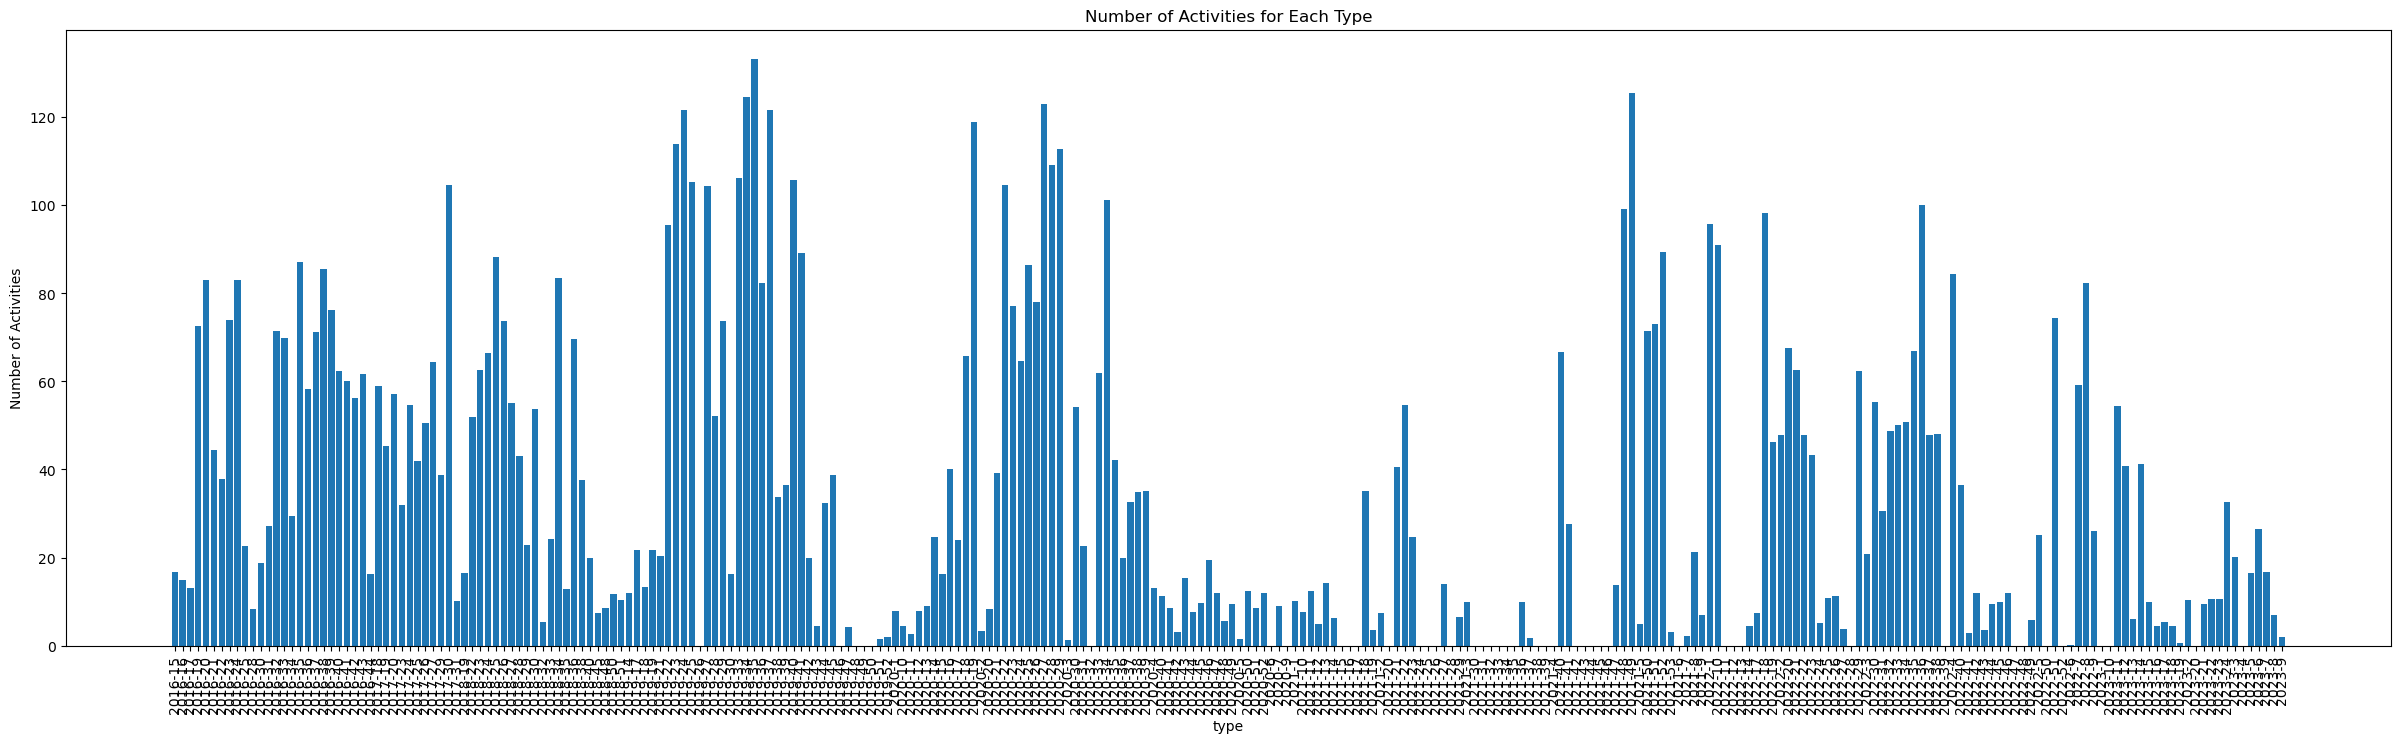

In [16]:
# Plot the number of activities for each start_date
df_plot = df_summary_weekly[df_summary_weekly['type'] == 'Ride']

plt.figure(figsize=(30,8))
plt.bar(df_summary_weekly['year_week'], df_summary_weekly['Sum of distance_km'])

plt.xlabel('type')
plt.ylabel('Number of Activities')
plt.title('Number of Activities for Each Type')

# Rotate x-axis tick labels horizontally
plt.xticks(rotation=90)

plt.show()

## Let's do one POC week

In [ ]:
df_poc_all = df[df['year_week'] == '2020-25']
df_poc_daily = df_summary_daily[df_summary_daily['year_week'] == '2020-25']
df_poc_summary_weekly = df_summary_weekly[df_summary_weekly['year_week'] == '2020-25']

In [ ]:
df_poc_daily.head(10)

year_week       date     type  Sum of distance_km  Count activites  \
562   2020-25 2020-06-15     Ride              6.0841                2   
563   2020-25 2020-06-15  Workout              0.0000                2   
564   2020-25 2020-06-16      Run             17.6019                2   
565   2020-25 2020-06-17     Ride             22.8396                3   
566   2020-25 2020-06-17     Swim              0.8515                1   
567   2020-25 2020-06-18     Ride             15.0016                2   
568   2020-25 2020-06-19     Ride             35.1763                1   
569   2020-25 2020-06-20     Ride              7.3610                2   
570   2020-25 2020-06-20     Walk              6.1069                1   

     Sum of elapsed_time_minutes  Sum of moving_time_minutes  
562                    41.733333                   41.733333  
563                    48.583333                   48.583333  
564                   108.450000                  106.250000  
565                    67.900000                   67.033333  
566                    31.816667                   31.816667  
567                    52.550000                   46.233333  
568                    99.883333                   90.850000  
569                    24.166667                   24.166667  
570                   112.466667                   99.433333

In [ ]:
# Group the data by year_week and type, and calculate the sum of distance for each group
grouped_data = df_poc_daily.groupby(['date', 'type'])['Sum of distance_km'].sum().unstack()
grouped_data

type           Ride      Run    Swim    Walk  Workout
date                                                 
2020-06-15   6.0841      NaN     NaN     NaN      0.0
2020-06-16      NaN  17.6019     NaN     NaN      NaN
2020-06-17  22.8396      NaN  0.8515     NaN      NaN
2020-06-18  15.0016      NaN     NaN     NaN      NaN
2020-06-19  35.1763      NaN     NaN     NaN      NaN
2020-06-20   7.3610      NaN     NaN  6.1069      NaN

In [ ]:
df_poc_daily['year_week'].unique()[0]

'2020-25'

C:\Users\arnarh\AppData\Local\Temp\ipykernel_4644\3416330816.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10', len(types))


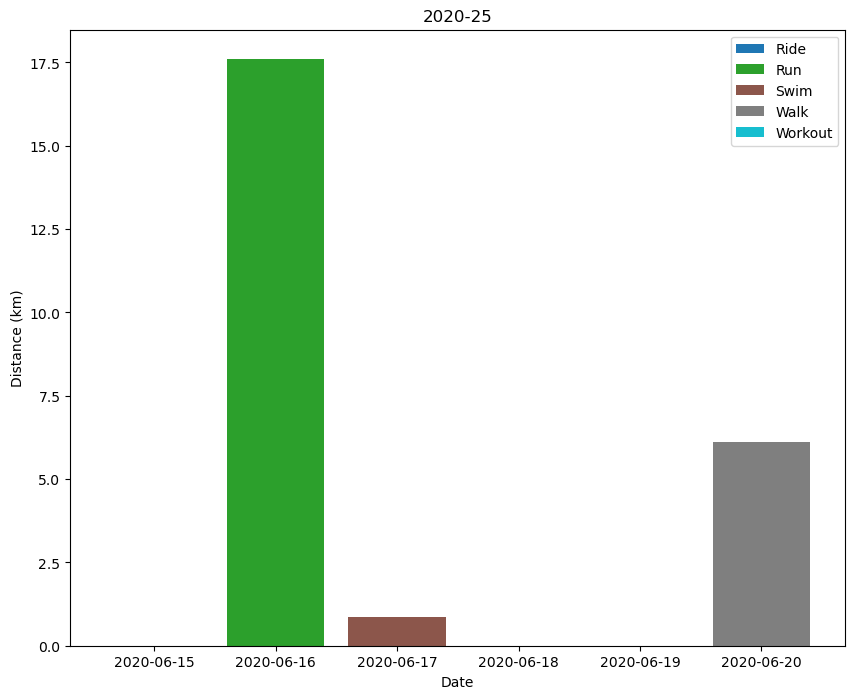

In [ ]:
# what is the week
week = df_poc_daily['year_week'].unique()[0]

# Get the unique types as the column names
types = grouped_data.columns.tolist()

# Get the unique types as the column names
types = grouped_data.columns.tolist()

# Get the x-axis values (year_week)
x = grouped_data.index

# Plot the stacked column chart with colored bars
plt.figure(figsize=(10, 8))
bars = []
cmap = cm.get_cmap('tab10', len(types))
for i, type in enumerate(types):
    bar = plt.bar(x, grouped_data[type], label=type, color=cmap(i))
    bars.append(bar)

plt.xlabel('Date')
plt.ylabel('Distance (km)')
plt.title(f'{week}')
plt.legend()

plt.show()


# Plotting

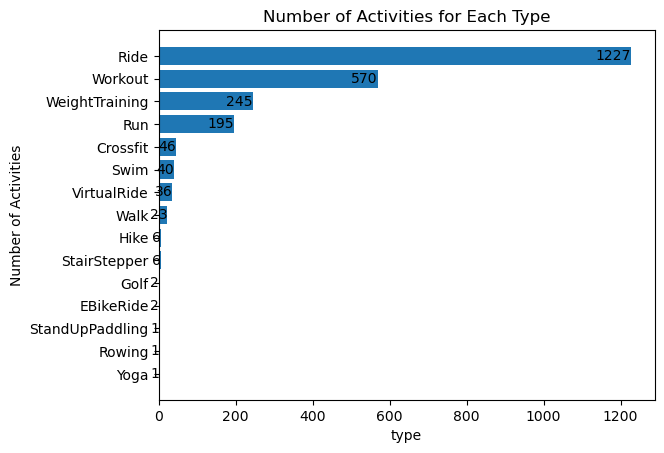

In [ ]:
# Count the occurrences of each start_date
activity_counts = df['type'].value_counts().sort_values(ascending=True)

# Plot the number of activities for each start_date
#activity_counts.plot(kind='bar', figsize=(14, 6))
plt.barh(activity_counts.index, activity_counts)

plt.xlabel('type')
plt.ylabel('Number of Activities')
plt.title('Number of Activities for Each Type')

# Add labels to the bars
for i, count in enumerate(activity_counts):
    plt.text(count, i, str(count), ha='right', va='center')

plt.show()

In [145]:
df_summary_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1602 entries, 0 to 1601
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   year                      1602 non-null   int64         
 1   year_week                 1602 non-null   object        
 2   date                      1602 non-null   datetime64[ns]
 3   month                     1602 non-null   object        
 4   type                      1602 non-null   object        
 5   sum_distance_km           1602 non-null   float64       
 6   count_activites           1602 non-null   int64         
 7   sum_elapsed_time_minutes  1602 non-null   float64       
 8   sum_moving_time_minutes   1602 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 112.8+ KB


In [74]:
df_summary_daily

year year_week       date     month            type  Sum of distance_km  \
0     2016   2016-15 2016-04-15     April            Ride              4.3717   
1     2016   2016-15 2016-04-16     April            Ride              3.8171   
2     2016   2016-15 2016-04-17     April            Ride              8.6018   
3     2016   2016-16 2016-04-18     April            Ride             15.0014   
4     2016   2016-17 2016-04-26     April            Ride              6.6897   
...    ...       ...        ...       ...             ...                 ...   
1597  2023    2023-7 2023-02-17  February  WeightTraining              0.0000   
1598  2023    2023-7 2023-02-19  February             Run              5.6596   
1599  2023    2023-8 2023-02-21  February             Run              7.0322   
1600  2023    2023-9 2023-03-01     March             Run              2.0355   
1601  2023    2023-9 2023-03-03     March  WeightTraining              0.0000   

      Count activites  Sum of elapsed_time_minutes  Sum of moving_time_minutes  
0                   1                    20.250000                   17.466667  
1                   1                  1758.633333                   10.416667  
2                   2                    30.416667                   29.350000  
3                   4                    50.400000                   47.816667  
4                   2                    22.583333                   21.383333  
...               ...                          ...                         ...  
1597                1                    17.033333                   17.033333  
1598                1                    42.750000                   39.566667  
1599                1                    49.466667                   47.233333  
1600                1                    16.666667                   15.000000  
1601                1                    30.416667                   30.416667  

[1602 rows x 9 columns]

In [543]:
# Creating a date dataframe to join with df_process to be able to show a continous timeseries
start_date = '2016-01-01'
current_date = pd.to_datetime('today')
end_date = current_date + pd.offsets.YearEnd()

date_df = pd.DataFrame({
    'date': pd.date_range(start=start_date, end=end_date, freq='D')
})

date_df['year'] = date_df['date'].dt.year
date_df['day'] = date_df['date'].dt.day
date_df['week'] = date_df['date'].dt.week
date_df['month'] = date_df['date'].dt.month
date_df['monthName'] = date_df['date'].dt.strftime('%B')
date_df['year_week'] = date_df['date'].dt.strftime('%Y-%U')

date_df.head(2)

C:\Users\arnarh\AppData\Local\Temp\ipykernel_29608\1717031215.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  date_df['week'] = date_df['date'].dt.week


date  year  day  week  month monthName year_week
0 2016-01-01  2016    1    53      1   January   2016-00
1 2016-01-02  2016    2    53      1   January   2016-00

In [660]:
# choosing columns to be able to select in the infographic
cols = ['date', 'type', 'sum_distance_km',
    'count_activites', 'sum_elapsed_time_minutes',
       'sum_moving_time_minutes']
# selecting a type
df_process = df_summary_daily[cols][df_summary_daily['type'] == 'Ride'].copy()
# merging the date dataframe for a continous dataframe
df_process = pd.merge(date_df, df_process, on='date', how='left')
# 0 where there is NA
df_process['sum_distance_km'] = df_process['sum_distance_km'].fillna(0)
df_process['sum_elapsed_time_minutes'] = df_process['sum_elapsed_time_minutes'].fillna(0)
df_process['sum_moving_time_minutes'] = df_process['sum_moving_time_minutes'].fillna(0)
df_process['count_activites'] = df_process['count_activites'].fillna(0)
df_process['type'] = df_process['type'].fillna(df_process['type'][~df_process['type'].isna()].unique()[0])

# Yearly infograph for a choosen activity

## Veeeery cool

<em> Code adjusted from this repo https://github.com/Perishleaf/data-visualisation-scripts/tree/master/matplotlib_2019_temp </em>

In [672]:
def infograph(df_infograph: pd.DataFrame, measure: str):

    """
    This function takes in a Strava activity dataframe and ouputs a infograph of bar charts
    for each year and a choosen measure, e.g. distance in km or number of activities.

    Parameters:
        - df is a Pandas dataframe that holds some activity data and date information. Minimum set of
            columns are ['date','year','type','measure'] so the function works
        - measure is the name of a column in the dataframe that holds the measure that the
            infographic is built on, e.g. "sum_distance_km"

    """

    # Error handling in function parameters
    if not isinstance(df_infograph, pd.DataFrame):
        raise TypeError("df should be a Pandas Dataframe.")
    if not isinstance(measure, str):
        raise TypeError("measure should be a string.")
    if 'date' not in df_infograph.columns or 'type' not in df.columns:
            raise KeyError("The 'date' and 'type' columns are required.")
    if measure not in df_infograph.columns:
            raise KeyError(f"The measure {measure} is not in the DataFrame you supplied.")


    # Multiplier function to round to nearest dozen number
    def round_multiple(number, multiple):
        if number <= 5:
            return number
        else:
            return multiple * round(number/multiple)

    # Set up plot style
    from matplotlib import cycler
    colors = cycler('color',
                    ['#fc280f', '#5fdcff', '#f4ba26', '#85c54c', '#c6d7e0'])
    plt.rc('figure', facecolor='#222222')
    plt.rc('axes', facecolor='#222222', edgecolor='#222222',
        axisbelow=True, grid=True, prop_cycle=colors) # "axisbelow" set axis ticks and gridlines are below all artists
    plt.rc('grid', color='#e3e3e3', linestyle='solid')
    plt.rc('xtick', direction='in', color='#e3e3e3')
    plt.rc('ytick', direction='in', color='#e3e3e3')
    plt.rc('patch', edgecolor='#e3e3e3')
    plt.rc('lines', linewidth=1.5)


    # Select one year to build the big x-axis in the top of the graphic
    df_one_year = df_infograph[df_infograph['year'] == min(df_infograph['year'])]
    # Global variables used in the loops
    year_list = df_infograph['year'].unique()
    global_max = max(df_infograph[measure])

    # Set canvas background color the same as axes
    plt.rc('figure', facecolor='#222222')

    # Set constrained_layout as True to avoid axes overlap
    fig = plt.figure(figsize=(10,12), dpi=300, constrained_layout=True)
    # Use GridSpec for customising laypout
    gs = fig.add_gridspec(nrows=len(df_infograph['year'].unique())+1, ncols=10) # +1 for the title row

    # Set up an empty axes that occupies 1 row and all columns for text
    ax_text = fig.add_subplot(gs[0:1, :])
    # Turn off all grid, ticks & spines
    ax_text.grid(False)
    ax_text.get_yaxis().set_visible(False)
    # Add text in the Axes coordinates
    type = df_infograph['type'].unique()[0]
    # Title
    ax_text.text(0.5, 0.8, f"Strava {type}", 
            verticalalignment='center', horizontalalignment='center',
            fontsize=30, color='#e3e3e3', fontweight='bold',
            transform=ax_text.transAxes)
    # Subtitle
    ax_text.text(0.5, 0.5, f"{measure}", 
            verticalalignment='center', horizontalalignment='center',
            fontsize=12, color='#e3e3e3', fontweight='bold',
            transform=ax_text.transAxes)

    # The months x-axis on top of the image
    # Build an empty axes for the months
    ax_text.bar(df_one_year.date, 0, label='_1',
            width=1.5, align="edge", zorder=1)
    # Adjustment for x-axis tick and tickLabel
    ax_text.tick_params(axis="x", direction="out", which='major', width=2, length=15)
    ax_text.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) # Show major tick every month
    ax_text.xaxis.set_major_formatter(mdates.DateFormatter("")) # Don't Show tick label
    for i, mon in enumerate(calendar.month_abbr[1:13]):
        ax_text.text(0.079*(i*0.96+1), -0.1, mon,
                    verticalalignment='center', horizontalalignment='center',
                    fontsize=8, color='#e3e3e3', fontweight='bold',
                    transform=ax_text.transAxes)

    # The color gradient bar
    ax_inlet = fig.add_axes([0.9, 0.97, 0.2, 0.01], frameon=False)
    # construct dummy value for color bar, length of x and y should be the same
    x_legend = np.linspace(0, round_multiple(max(df_infograph[measure]),5), 1800)
    y_legend = np.linspace(0, round_multiple(max(df_infograph[measure]),5), 1800)
    # Turn off all grid, ticks & spines
    ax_inlet.grid(False)
    ax_inlet.get_yaxis().set_visible(False)
    # This line generates a colormap based on the RdYlBu_r.
    colors_inlet = cm.RdYlBu_r(y_legend / max(y_legend))
    # Create a bar plot in te ax_inlet subplot
    ax_inlet.bar(x_legend, y_legend**0, label='_1', color=colors_inlet, align="center", zorder=0)
    ax_inlet.tick_params(axis="x", direction="out", pad=2)
    # # Lambda function to determine the maximum value the MultipleLocator
    multipleLocator_value = lambda x: 1 if x < 10 else (10 if 10 <= x <= 100 else 100)
    multipleLocator_value = multipleLocator_value(global_max)
    ax_inlet.xaxis.set_major_locator(MultipleLocator(multipleLocator_value))
    # Format x-axis tick labels as integers
    ax_inlet.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    # Set the font size for x-axis tick labels
    ax_inlet.tick_params(axis="x", labelsize=5)

    for i, year in enumerate(year_list):
        ax = fig.add_subplot(gs[i+1, :], ylim=(0, global_max + 10))
        
        df_tmp = df_infograph.loc[df_infograph['year'] == year]
        # Color scheme
        colors = cm.RdYlBu_r((df_tmp[measure]) / global_max)
        ax.bar(df_tmp['date'], df_tmp[measure], label='_1', color=colors,
            width=0.7, align="edge")

        # Annotation for highest measure
        max_measure = max(df_tmp[measure])
        max_indices = df_tmp[df_tmp[measure] == max_measure].index
        # Only show annotation if there is a distinct value, if not skip the annotation
        if len(max_indices) == 1:
            index = max_indices[0]
            high_date = df_tmp.loc[index, 'date']
            high_count_activities = df_tmp.loc[index, 'count_activites']
            high_date_label = high_date.strftime('%m/%d/%Y')
            
            if 'distance' in measure:
                annotation_text = f"{round(max_measure)} km on {high_date_label} \nnumber of {str.lower(type)}s: {int(high_count_activities)}"
            elif 'minutes' in measure:
                annotation_text = f"{round(max_measure)} minutes on {high_date_label} \nnumber of {str.lower(type)}s: {int(high_count_activities)}"
            elif 'count' in measure:
                annotation_text = f"{round(max_measure)} {type} on {high_date_label}"
            else:
                None
            
            ax.annotate(annotation_text,
                        xy=(high_date, max_measure), xycoords='data',
                        xytext=(high_date+timedelta(days=10), max_measure+5), textcoords='data',
                        size=6,
                        color='#e3e3e3',
                        arrowprops=dict(arrowstyle="->",
                                        connectionstyle="arc3, rad=.3",
                                        color='#e3e3e3')
                    )
        # Customise axes
        ax.spines['bottom'].set_color(None)
        ax.spines['right'].set_color(None)  
        ax.spines['left'].set_color(None)  
        ax.spines['top'].set_color(None) 
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel(df_tmp['year'].unique()[0], rotation=0, color='#e3e3e3', fontsize=10, fontweight='bold')

    plt.show()

In [652]:
df_process.columns

Index(['date', 'year', 'day', 'week', 'month', 'monthName', 'year_week',
       'type', 'sum_distance_km', 'count_activites',
       'sum_elapsed_time_minutes', 'sum_moving_time_minutes'],
      dtype='object')

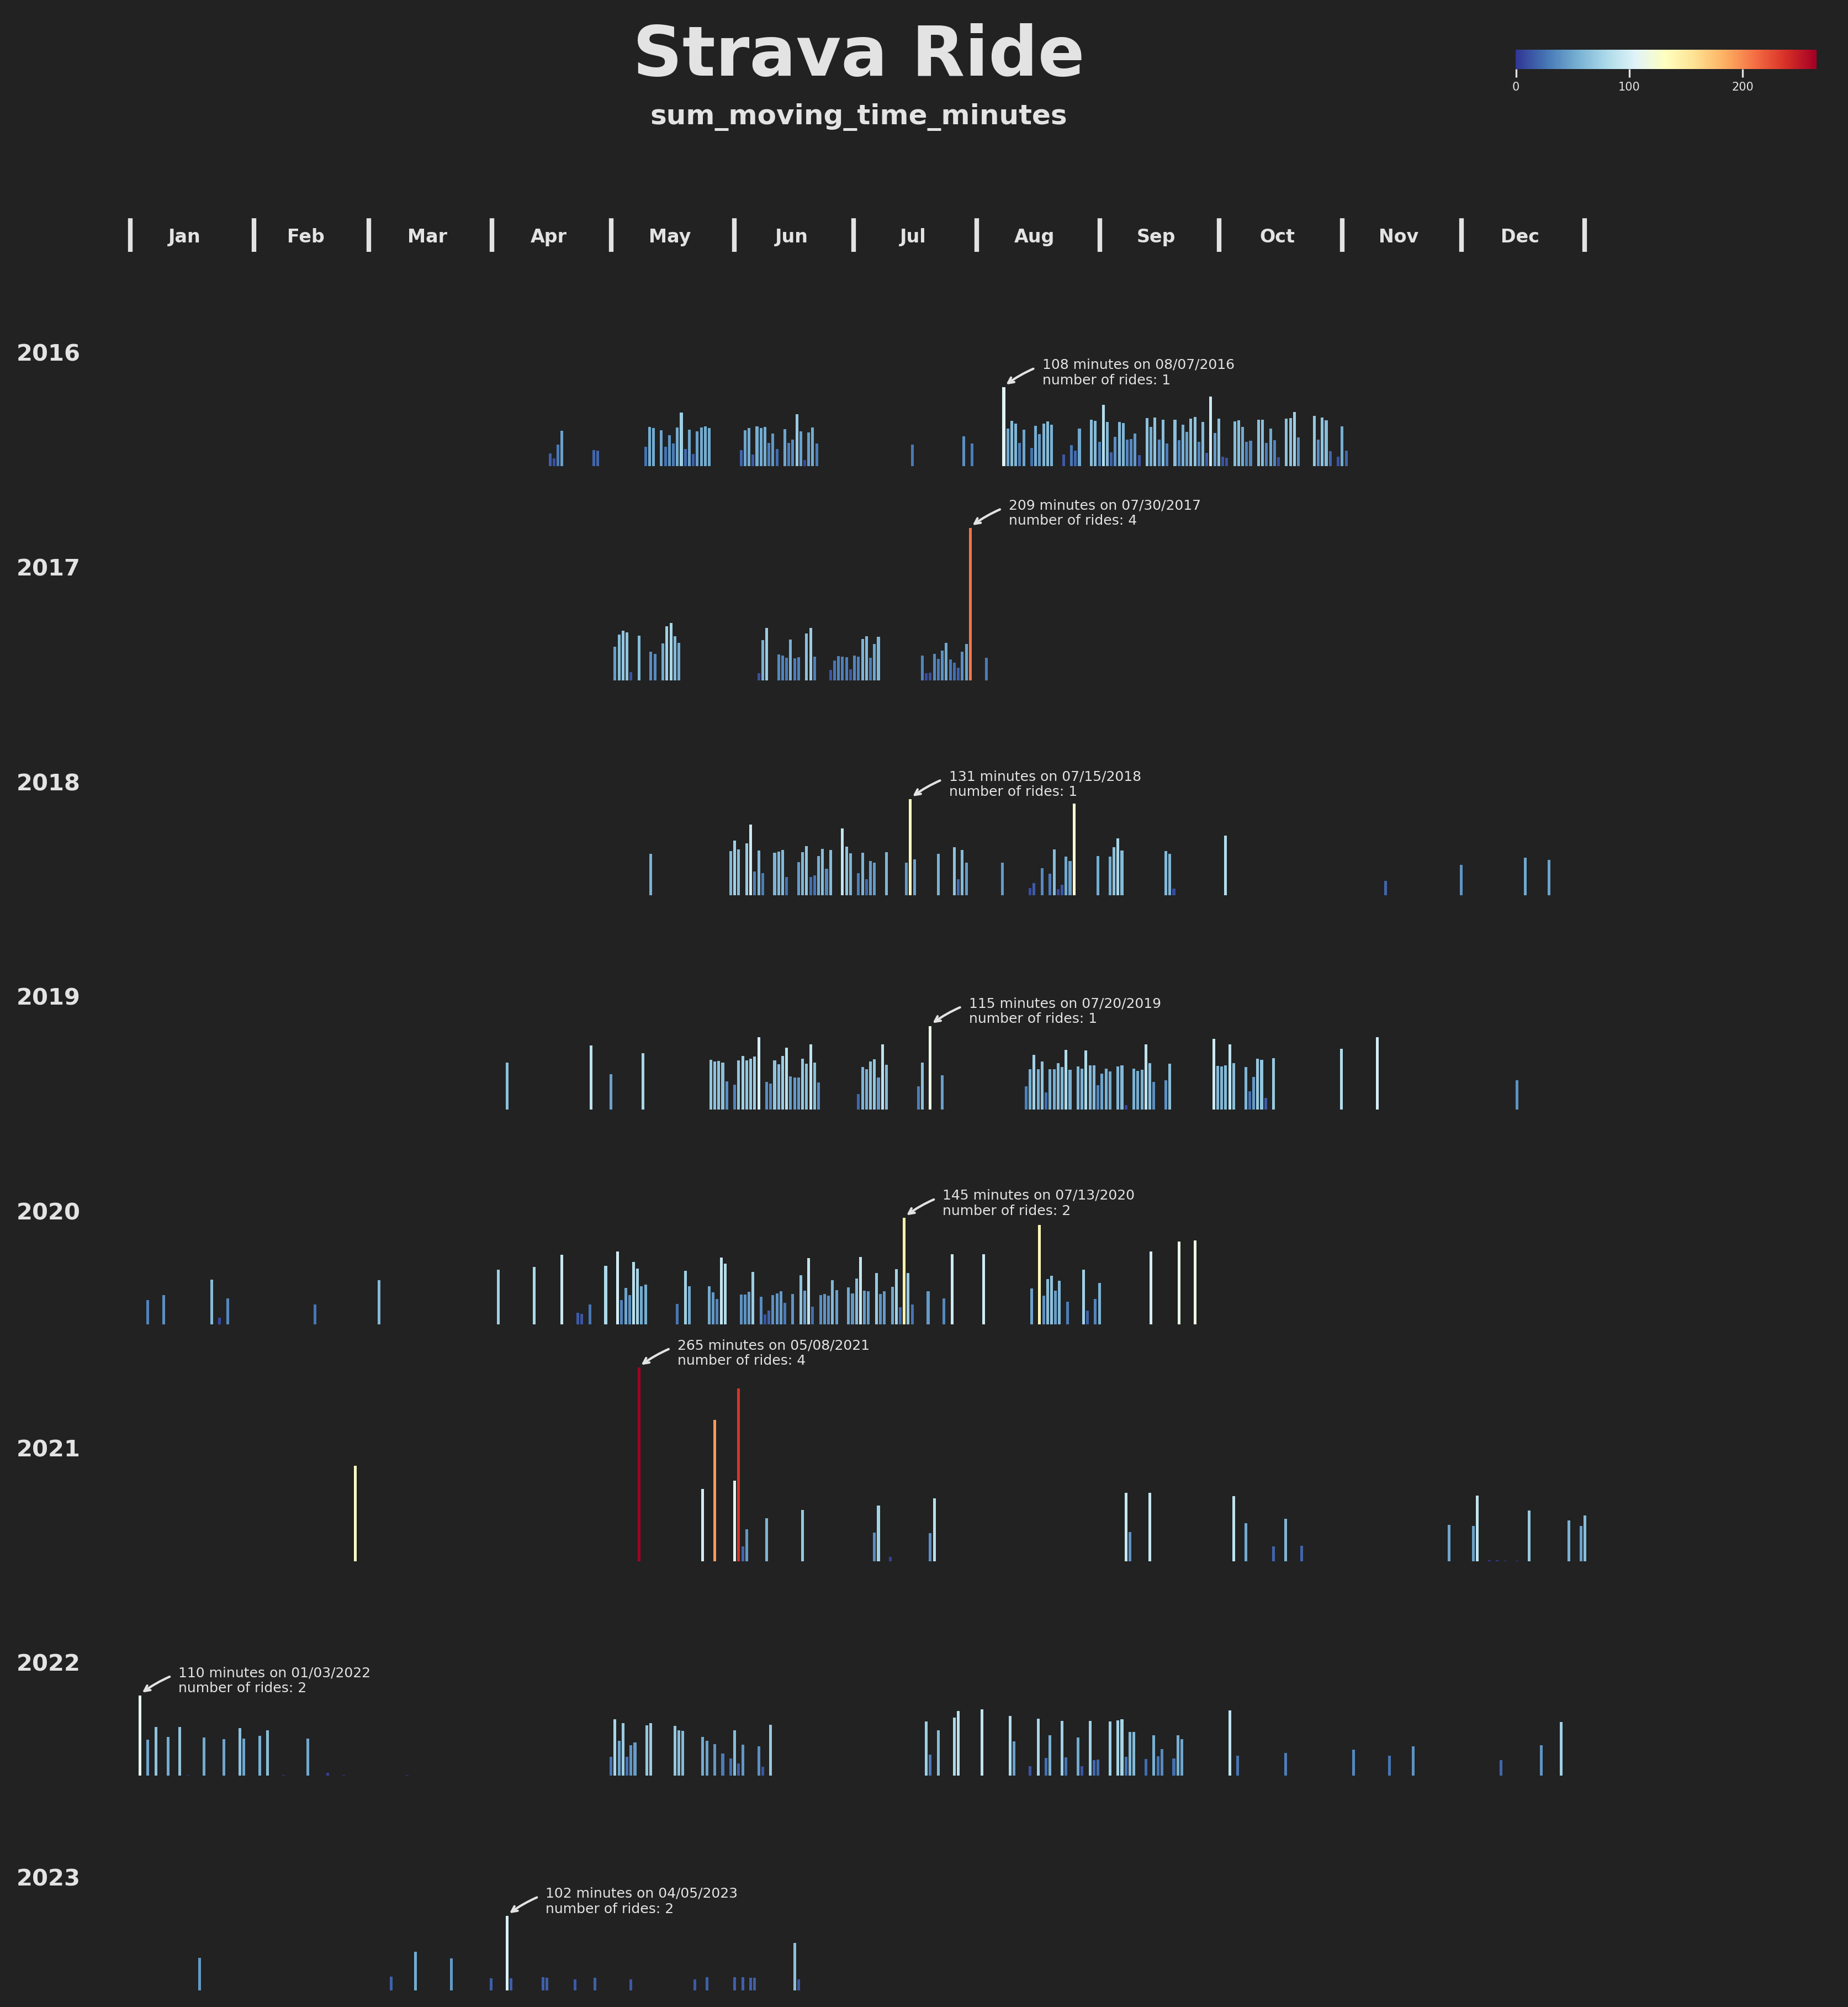

In [673]:
infograph(df_process, "sum_moving_time_minutes")

# Mapping - Polylines

In [684]:
df.head()

resource_state                       name  distance  moving_time  \
0               3             Afternoon Ride    2625.1          432   
1               3          Afternoon Workout       0.0         3885   
2               3             Afternoon Ride    2591.5          468   
3               3  Afternoon Weight Training       0.0         2613   
4               3             Afternoon Ride   27297.2         3882   

   elapsed_time  total_elevation_gain            type      sport_type  \
0           432                   8.0            Ride            Ride   
1          3885                   0.0         Workout         Workout   
2           488                  39.0            Ride            Ride   
3          2613                   0.0  WeightTraining  WeightTraining   
4          3926                 200.0            Ride            Ride   

   workout_type          id                start_date      start_date_local  \
0           NaN  9284284353 2023-06-17 17:59:09+00:00  2023-06-17T17:59:09Z   
1           NaN  9284221687 2023-06-17 16:49:44+00:00  2023-06-17T16:49:44Z   
2           NaN  9283841624 2023-06-17 16:38:18+00:00  2023-06-17T16:38:18Z   
3           NaN  9277827977 2023-06-16 17:22:14+00:00  2023-06-16T17:22:14Z   
4           NaN  9276884908 2023-06-16 14:00:48+00:00  2023-06-16T14:00:48Z   

                         timezone  utc_offset location_country  \
0  (GMT+00:00) Atlantic/Reykjavik         0.0          Iceland   
1      (GMT+00:00) Africa/Abidjan         0.0          Iceland   
2  (GMT+00:00) Atlantic/Reykjavik         0.0          Iceland   
3      (GMT+00:00) Africa/Abidjan         0.0          Iceland   
4  (GMT+00:00) Atlantic/Reykjavik         0.0          Iceland   

   achievement_count  kudos_count  comment_count  athlete_count  photo_count  \
0                  0            0              0              1            0   
1                  0            0              0              1            0   
2                  2            0              0              1            0   
3                  0            0              0              1            0   
4                 27            0              0              1            0   

   trainer  commute  manual  private visibility  flagged   gear_id  \
0    False    False   False     True    only_me    False  b7503439   
1     True    False   False     True    only_me    False      None   
2    False    False   False     True    only_me    False  b7503439   
3     True    False   False     True    only_me    False      None   
4    False    False   False     True    only_me    False  b7503439   

                               start_latlng  \
0   [64.13658767938614, -21.75912600941956]   
1                                        []   
2  [64.15314671583474, -21.771167954429984]   
3                                        []   
4  [64.15290037170053, -21.772008575499058]   

                                 end_latlng  average_speed  max_speed  \
0  [64.15261480025947, -21.772179901599884]          6.077      8.620   
1                                        []          0.000      0.000   
2  [64.13656345568597, -21.758576575666666]          5.537      7.772   
3                                        []          0.000      0.000   
4    [64.15301755070686, -21.7714521009475]          7.032     11.246   

   average_watts  kilojoules device_watts  has_heartrate  average_heartrate  \
0           84.2        36.4        False           True              121.7   
1            NaN         NaN         None           True              130.6   
2          168.7        79.0        False           True              116.3   
3            NaN         NaN         None           True              110.8   
4          139.6       541.8        False           True              104.9   

   max_heartrate  heartrate_opt_out  display_hide_heartrate_option  elev_high  \
0          130.0              False                           True       73.6   
1   

In [685]:
# búa til nýja DF sem er id á activity og poly hnitin (one to many)

selected_types = ['Ride','Run','Hike']

mask = df['type'].isin(selected_types)
masked_df = df[mask]
masked_df = masked_df[masked_df['location_country'] == 'Iceland']

# selected columns
poly_df = masked_df[['id','type','date','map.polyline','start_latlng','end_latlng']].copy()
poly_df.replace('',np.nan,inplace=True)
poly_df = poly_df.dropna()
poly_df = poly_df.reset_index(drop=True)

c:\Users\arnarh\.conda\envs\strava\lib\site-packages\pandas\core\missing.py:95: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  new_mask = arr == x


In [686]:
poly_df.head()

id  type       date  \
0  9284284353  Ride 2023-06-17   
1  9283841624  Ride 2023-06-17   
2  9276884908  Ride 2023-06-16   
3  9259203332   Run 2023-06-13   
4  9219727211   Run 2023-06-07   

                                        map.polyline  \
0  stmfKpyxcC\JxBpAvA`AJ\B`AMd@MTm@h@_@PiAOiACm@F...   
1  c|pfKxd{cCGi@FyD@SH]z@eAzAuB^S|@WHGXUNSh@}@NK^...   
2  szpfK`j{cCFg@c@cBGoAAqDCQMKo@z@qAz@_@Ha@?OE{@k...   
3  _mnfK~}xcCA@aAE\LXDE?FPMP@FWN]Zm@N_@TUZa@v@q@j...   
4  obpfKdozdCZP?BUJKp@CNBHAN?NGn@BVDPPXRt@Pd@f@lA...   

                               start_latlng  \
0   [64.13658767938614, -21.75912600941956]   
1  [64.15314671583474, -21.771167954429984]   
2  [64.15290037170053, -21.772008575499058]   
3   [64.14048912003636, -21.75983687862754]   
4  [64.14904159493744, -21.931543853133917]   

                                 end_latlng  
0  [64.15261480025947, -21.772179901599884]  
1  [64.13656345568597, -21.758576575666666]  
2    [64.15301755070686, -21.7714521009475]  
3  [64.15283708833158, -21.771908663213253]  
4  [64.14924569427967, -21.932153552770615]

In [687]:
poly_df['decoded_polyline'] = poly_df['map.polyline'].apply(lambda x: polyline.decode(x))

In [688]:
fig = plt.figure(figsize=(12, 12))
fig.suptitle('Strava Map')

ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_aspect('equal')
ax.set_axis_off()
fig.add_axes(ax)

lines = []
labels = []


data = poly_df.iloc[375:380].reset_index()


for i in range(0, len(data)):
    type_value = data.loc[i,'type']
    date_value = data.loc[i,'date']
    coo = data.loc[i, 'decoded_polyline']
    lat, lon = zip(*coo)
    line, = plt.plot(lon, lat, lw=0.5, alpha=0.9)
    
    #Append line and label to the respective lists
    lines.append(line)
    labels.append(f'{type_value} on {date_value}')

#Add a legend with matching colors
plt.legend(handles=lines, labels=labels)

plt.show()

In [689]:
poly_df.iloc[375:380]

id  type       date  \
375  3704006177  Ride 2020-07-02   
376  3703791881  Ride 2020-07-02   
377  3701581900  Ride 2020-07-02   
378  3699989853  Ride 2020-07-01   
379  3699473478  Ride 2020-07-01   

                                          map.polyline  \
375  _{jfK~nydCQeBB@MkBGmACyD@uBJ_BJ{@lAsIHyANwDtAc...   
376  minfKpcqdCAVOdAM~AMzE?fABnDXhBFr@D~GFrEDf@At@I...   
377  cqgfKv`~cCAl@Et@CHoAjBELEb@B\d@hC[nB@~@NtB@v@E...   
378  uvbfKpfddC_@I}@s@KCc@?[Du@YMBOJk@h@o@ViCJQBOFq...   
379  iknfKtaqdCGZMlFIvBEtC?jBDnA\dCBj@NnFRrEB|BClAH...   

                start_latlng               end_latlng  \
375  [64.122246, -21.926399]  [64.104884, -21.784277]   
376  [64.139917, -21.883606]  [64.121751, -21.928361]   
377   [64.105309, -21.78588]   [64.13951, -21.883096]   
378  [64.080591, -21.817528]  [64.104753, -21.784393]   
379  [64.140215, -21.883303]  [64.079894, -21.819126]   

                                      decoded_polyline  
375  [(64.12224, -21.9264), (64.12233, -21.92589), ...  
376  [(64.13991, -21.88361), (64.13992, -21.88373),...  
377  [(64.1053, -21.78588), (64.10531, -21.78611), ...  
378  [(64.08059, -21.81753), (64.08075, -21.81748),...  
379  [(64.14021, -21.88331), (64.14025, -21.88345),...

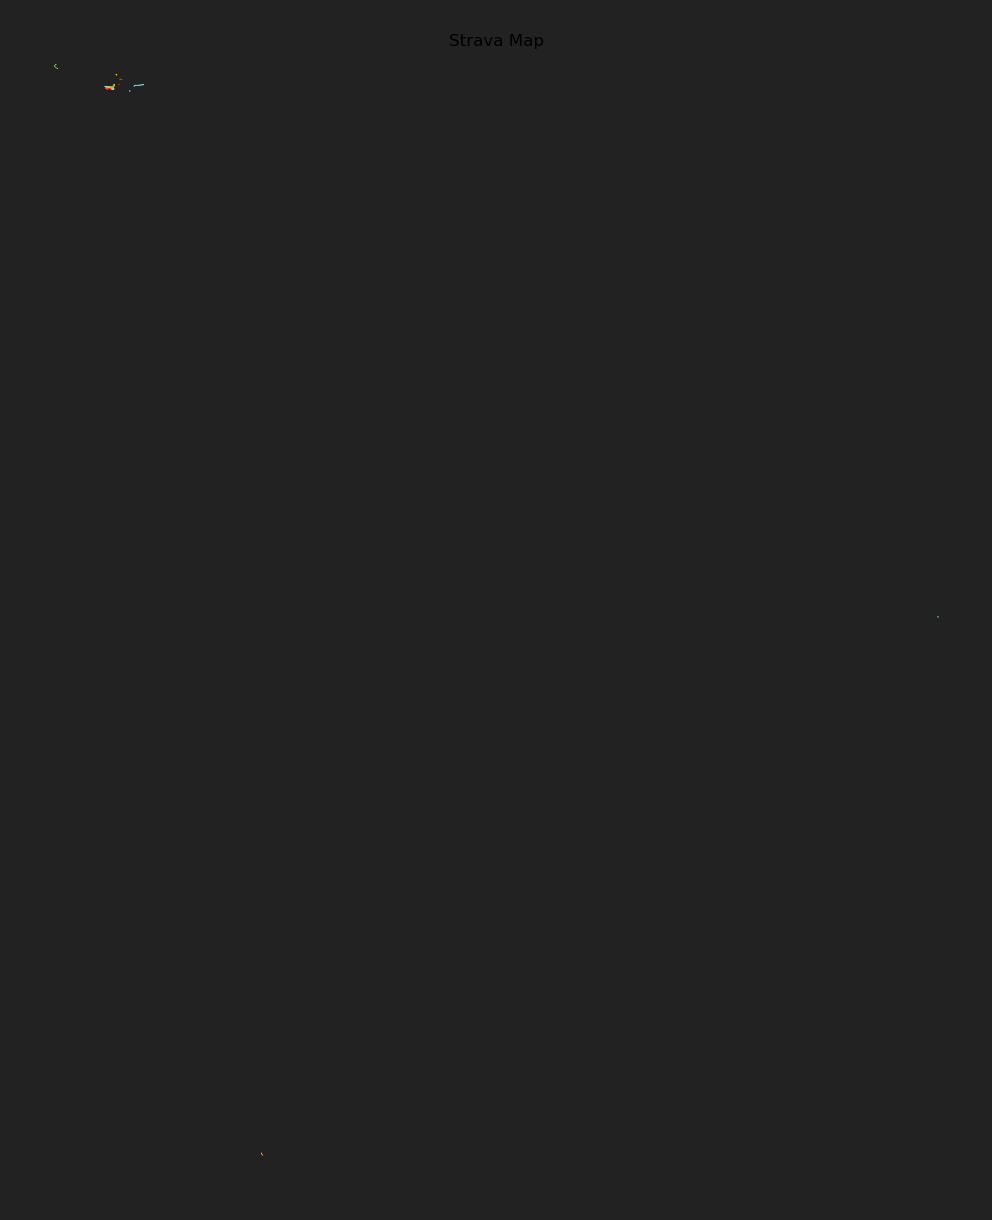

In [690]:
fig = plt.figure(figsize=(12, 12))
fig.suptitle('Strava Map')

ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_aspect('equal')
ax.set_axis_off()
fig.add_axes(ax)

lines = []
labels = []


data = poly_df.iloc[:].reset_index()
snaefellsnes_hlaup = [378,379]
data = data.drop(index=snaefellsnes_hlaup).reset_index() # drop these rows just so the image looks nicer


for i in range(0, len(data)):
    type_value = data.loc[i,'type']
    date_value = data.loc[i,'date']
    coo = data.loc[i, 'decoded_polyline']
    lat, lon = zip(*coo)
    line, = plt.plot(lon, lat, lw=0.5, alpha=0.9)

plt.show()

In [691]:
data = poly_df.iloc[:100].reset_index()
# data = poly_df

# split decoded_polyline into two columns
data[['latitude', 'longitude']] = pd.DataFrame(data['decoded_polyline'].apply(lambda x: list(zip(*x))).tolist(), columns=['latitude', 'longitude'])
# Extract latitude and longitude using a lambda function
# data['StartLatitude'] = data['start_latlng'].apply(lambda x: x[0])
# data['StartLongitude'] = data['start_latlng'].apply(lambda x: x[1])
# data['EndLatitude'] = data['end_latlng'].apply(lambda x: x[0])
# data['EndLongitude'] = data['end_latlng'].apply(lambda x: x[1])

data = data.drop(['map.polyline','decoded_polyline','start_latlng','end_latlng'],axis=1)

# create a new line for each latitude and longitude pairing from decoded_polyline
df_plotly = data.explode(['latitude', 'longitude'], ignore_index=True).reset_index()
df_plotly = df_plotly.drop('index',axis=1)


In [692]:
df_plotly

level_0          id  type       date  latitude longitude
0            0  9284284353  Ride 2023-06-17  64.13658 -21.75913
1            1  9284284353  Ride 2023-06-17  64.13643 -21.75919
2            2  9284284353  Ride 2023-06-17  64.13582  -21.7596
3            3  9284284353  Ride 2023-06-17  64.13538 -21.75993
4            4  9284284353  Ride 2023-06-17  64.13532 -21.76008
...        ...         ...   ...        ...       ...       ...
23735    23735  7682664178  Ride 2022-08-22  64.15273 -21.77219
23736    23736  7682664178  Ride 2022-08-22   64.1527  -21.7721
23737    23737  7682664178  Ride 2022-08-22  64.15266 -21.77203
23738    23738  7682664178  Ride 2022-08-22   64.1525 -21.77188
23739    23739  7682664178  Ride 2022-08-22  64.15249 -21.77189

[23740 rows x 6 columns]

In [693]:
import plotly.graph_objects as go

# Group the dataframe by ID
groups = df_plotly.groupby('id')

# Create an empty list to store the traces
traces = []

# Iterate over each group and create a separate trace
for id_val, group in groups:
    trace = go.Scattermapbox(
        lat=group['latitude'],
        lon=group['longitude'],
        mode='lines',
        line=dict(width=2)
        ,
        name=f'({group["type"].iloc[0]} on {group["date"].iloc[0]})'
    )
    traces.append(trace)

# Create the layout for the map
layout = go.Layout(
    mapbox=dict(
        center=dict(lat=df_plotly['latitude'].mean(), lon=df_plotly['longitude'].mean()),
        style='carto-darkmatter',
        zoom=13,
    ),
        height=800,
        width=1000,
        showlegend=False,
)

# Create the figure with the traces and layout
fig = go.Figure(data=traces, layout=layout)

# Show the figure
fig.show()

In [694]:
# The more you run / ride on a road the brighter / darker the color should be

# Group the dataframe by ID
groups = df_plotly.groupby('id')

# Create an empty list to store the traces
traces = []

# Iterate over each group and create a separate trace
for id_val, group in groups:
    trace = go.Densitymapbox(
        lat=group['latitude'],
        lon=group['longitude'],
        radius=5,
        colorscale='Hot',
        zauto=True,
        name=f'({group["type"].iloc[0]} on {group["date"].iloc[0]})'
    )
    traces.append(trace)

# Create the layout for the map
layout = go.Layout(
    mapbox=dict(
        center=dict(lat=df_plotly['latitude'].mean(), lon=df_plotly['longitude'].mean()),
        style='open-street-map',
        zoom=13,
    ),
    height=800,
    width=1000,
    showlegend=False,
)

# Create the figure with the traces and layout
fig = go.Figure(data=traces, layout=layout)

# Show the figure
fig.show()

In [695]:
# Calculate density values based on the frequency of latitude and longitude
density_values = df_plotly.groupby(['latitude', 'longitude']).size().reset_index(name='density')

# Create the Densitymapbox trace using density values
trace = go.Densitymapbox(
    lat=density_values['latitude'],
    lon=density_values['longitude'],
    z=density_values['density'],
    radius=10,
    colorscale='Viridis',
    zauto=True
)

# Create the layout for the map
layout = go.Layout(
    mapbox=dict(
        center=dict(lat=df_plotly['latitude'].mean(), lon=df_plotly['longitude'].mean()),
        style='carto-darkmatter',
        zoom=13,
    ),
    height=800,
    width=1000,
    showlegend=False
)

# Create the figure with the trace and layout
fig = go.Figure(data=trace, layout=layout)

# Show the figure
fig.show()

In [696]:
import plotly.express as px

# two-line code
fig = px.scatter_mapbox(df_plotly, lat="latitude", lon="longitude", color="type", zoom=3, mapbox_style='open-street-map')

fig.show()